**Paper Implementation**

In [1]:
# ==============================================================
# classic_ml_models_with_cv.py
# ==============================================================
import pandas as pd
import numpy as np
import pickle, joblib, os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report

# ==============================================================
# Step 1: Load & clean data
# ==============================================================
data_path = "/kaggle/input/dataset.csv"
df = pd.read_csv(data_path)
print("Original shape:", df.shape)
df.dropna(inplace=True)
print("After dropping nulls:", df.shape)

# Balanced subset
df_balanced = df.groupby('track_genre').sample(n=300, random_state=42).reset_index(drop=True)

# Drop unused columns
drop_cols = ['track_id', 'artists', 'album_name', 'track_name']
df_balanced.drop(columns=drop_cols, inplace=True)

# ==============================================================
# Step 2: Split features / labels
# ==============================================================
target_col = 'track_genre'
X = df_balanced.drop(columns=[target_col])
y = df_balanced[target_col]

categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor_scaled = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

preprocessor_unscaled = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split (for later reports)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

os.makedirs("saved_models", exist_ok=True)

# ==============================================================
# Step 3: Define models
# ==============================================================
models = {
    "Perceptron": Perceptron(max_iter=1000, random_state=42),
    "RBF SVM": SVC(kernel="rbf", class_weight="balanced", random_state=42),
    "Sig SVM": SVC(kernel="sigmoid", class_weight="balanced", random_state=42),
    "Poly SVM": SVC(kernel="poly", class_weight="balanced", random_state=42)
}

# ==============================================================
# Step 4: 5-fold cross-validation (scaled & unscaled)
# ==============================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for scale_name, preproc in [("Scaled", preprocessor_scaled), ("Unscaled", preprocessor_unscaled)]:
    for model_name, model in models.items():
        pipe = Pipeline([('preprocess', preproc), ('clf', model)])
        scores = cross_val_score(pipe, X, y_encoded, cv=cv, scoring='accuracy', n_jobs=-1)
        results.append({
            "Model": model_name,
            "Scaled/Unscaled": scale_name,
            "Mean Accuracy": round(scores.mean(), 3),
            "Std": round(scores.std(), 3)
        })
        print(f"{model_name} ({scale_name}) -> {scores.mean():.3f} (±{scores.std():.3f})")

# ==============================================================
# Step 5: Save CV summary table
# ==============================================================
cv_results = pd.DataFrame(results)
cv_results.to_csv("saved_models/cv_results_table.csv", index=False)
print("\n📊 Cross-Validation Summary (Table 1):\n")
print(cv_results.pivot(index="Model", columns="Scaled/Unscaled", values="Mean Accuracy").round(3))
print("\n✅ Saved as 'saved_models/cv_results_table.csv'")

# ==============================================================
# Step 6: Fit best models on full training set (optional)
# ==============================================================
# Example: Random Forest (keep same as before for fairness)
rf_pipe = Pipeline([
    ('preprocess', preprocessor_scaled),
    ('rf', RandomForestClassifier(
        n_estimators=500, min_samples_split=5,
        class_weight='balanced', random_state=42, n_jobs=-1))
])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("\n🌲 Random Forest Test Accuracy:", round(acc_rf, 3))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))
joblib.dump(rf_pipe, "saved_models/random_forest.pkl")

# Save label encoder
with open("saved_models/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


Original shape: (114000, 21)
After dropping nulls: (113999, 21)
Perceptron (Scaled) -> 0.151 (±0.008)
RBF SVM (Scaled) -> 0.514 (±0.004)
Sig SVM (Scaled) -> 0.290 (±0.007)
Poly SVM (Scaled) -> 0.461 (±0.002)
Perceptron (Unscaled) -> 0.020 (±0.004)
RBF SVM (Unscaled) -> 0.161 (±0.002)
Sig SVM (Unscaled) -> 0.022 (±0.003)
Poly SVM (Unscaled) -> 0.125 (±0.004)

📊 Cross-Validation Summary (Table 1):

Scaled/Unscaled  Scaled  Unscaled
Model                            
Perceptron        0.151     0.020
Poly SVM          0.461     0.125
RBF SVM           0.514     0.161
Sig SVM           0.290     0.022

✅ Saved as 'saved_models/cv_results_table.csv'

🌲 Random Forest Test Accuracy: 0.861
                   precision    recall  f1-score   support

         acoustic       0.98      1.00      0.99        60
         afrobeat       1.00      0.95      0.97        60
         alt-rock       0.94      0.97      0.95        60
      alternative       0.92      0.97      0.94        60
          ambi

Original shape: (114000, 21)
After dropping nulls: (113999, 21)
🎶 Number of genres (classes): 114
🧩 Training samples: torch.Size([91199, 16]), Features: 16
Epoch 000: Train Acc=0.75% | Test Acc=0.79%
Epoch 010: Train Acc=3.39% | Test Acc=4.92%
Epoch 020: Train Acc=7.12% | Test Acc=9.26%
Epoch 030: Train Acc=10.09% | Test Acc=13.05%
Epoch 040: Train Acc=13.19% | Test Acc=16.28%
Epoch 050: Train Acc=15.99% | Test Acc=19.13%
Epoch 060: Train Acc=18.01% | Test Acc=21.63%
Epoch 070: Train Acc=19.81% | Test Acc=24.07%
Epoch 080: Train Acc=21.60% | Test Acc=25.85%
Epoch 090: Train Acc=23.09% | Test Acc=27.43%


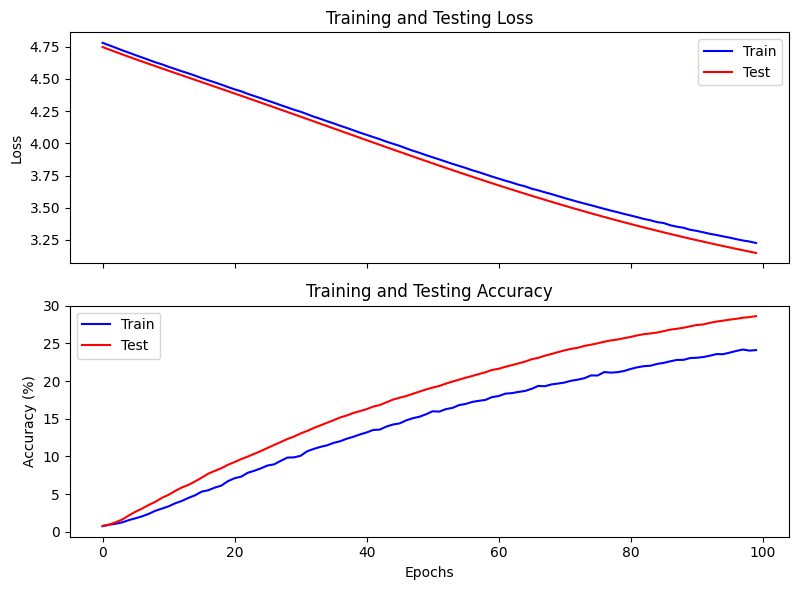


✅ Training complete. Model and label encoder saved.


In [1]:
# ===============================================================
# 🎵 PyTorch Neural Network for Spotify Genre Classification
# ===============================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ---------------------------------------------------------------
# 1️⃣ Load and preprocess dataset
# ---------------------------------------------------------------
data_path = "/kaggle/input/-spotify-tracks-dataset/dataset.csv"
df = pd.read_csv(data_path)
print("Original shape:", df.shape)

# Drop missing values
df.dropna(inplace=True)
print("After dropping nulls:", df.shape)

# Drop irrelevant columns
drop_cols = ['track_id', 'artists', 'album_name', 'track_name']
df.drop(columns=drop_cols, inplace=True)

# Encode target labels (genres)
target_col = 'track_genre'
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])
num_classes = len(le.classes_)
print(f"🎶 Number of genres (classes): {num_classes}")

# Separate features and labels
X = df.drop(columns=[target_col])
y = df[target_col]

# Handle categorical column ('explicit')
X = pd.get_dummies(X, columns=['explicit'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

print(f"🧩 Training samples: {X_train_tensor.shape}, Features: {X_train_tensor.shape[1]}")

# ---------------------------------------------------------------
# 2️⃣ Define Neural Network
# ---------------------------------------------------------------
class SpotifyNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SpotifyNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.logsoftmax(self.fc2(x))
        return x

# Initialize model
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = num_classes
model = SpotifyNN(input_dim, hidden_dim, output_dim)

# ---------------------------------------------------------------
# 3️⃣ Loss and Optimizer
# ---------------------------------------------------------------
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# ---------------------------------------------------------------
# 4️⃣ Training Loop
# ---------------------------------------------------------------
epochs = 100
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Evaluate on train/test
    model.eval()
    with torch.no_grad():
        # Train accuracy
        train_pred = torch.argmax(outputs, dim=1)
        train_acc = (train_pred == y_train_tensor).float().mean().item() * 100

        # Test accuracy
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor).item()
        test_pred = torch.argmax(test_outputs, dim=1)
        test_acc = (test_pred == y_test_tensor).float().mean().item() * 100

    train_losses.append(loss.item())
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}: Train Acc={train_acc:.2f}% | Test Acc={test_acc:.2f}%")

# ---------------------------------------------------------------
# 5️⃣ Plot Loss and Accuracy Curves
# ---------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), sharex=True)

ax1.plot(train_losses, label="Train", color='blue')
ax1.plot(test_losses, label="Test", color='red')
ax1.set_ylabel("Loss")
ax1.set_title("Training and Testing Loss")
ax1.legend()

ax2.plot(train_accs, label="Train", color='blue')
ax2.plot(test_accs, label="Test", color='red')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training and Testing Accuracy")
ax2.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 6️⃣ Save Model and Label Encoder
# ---------------------------------------------------------------
torch.save(model.state_dict(), "spotify_nn_model.pth")
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("\n✅ Training complete. Model and label encoder saved.")


Original shape: (114000, 21)
After dropping nulls: (113999, 21)
🎵 Number of classes: 114
🧩 Input features: 16, Classes: 114
TwoHiddenANN(
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (identity): Identity()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (fc3): Linear(in_features=64, out_features=114, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)
Epoch 000 | Train Acc: 21.93% | Test Acc: 33.67%
Epoch 010 | Train Acc: 66.04% | Test Acc: 66.08%
Epoch 020 | Train Acc: 71.17% | Test Acc: 70.96%
Epoch 030 | Train Acc: 73.15% | Test Acc: 72.26%
Epoch 040 | Train Acc: 73.98% | Test Acc: 73.93%
Epoch 050 | Train Acc: 74.48% | Test Acc: 74.26%
Epoch 060 | Train Acc: 74.96% | Test Acc: 74.71%
Epoch 070 | Train Acc: 75.31% | Test Acc: 74.72%
Epoch 080 | Train Acc: 75.46% | Test Acc: 75.82%
Epoch 090 | Train Acc: 75.45% | Test Acc: 75.46%
Epoch 099 | Train Acc: 75.47% | Test Acc: 75.33%


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


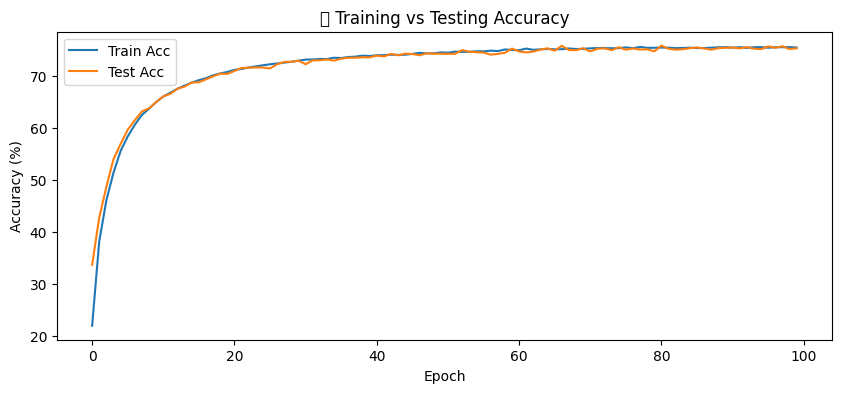

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


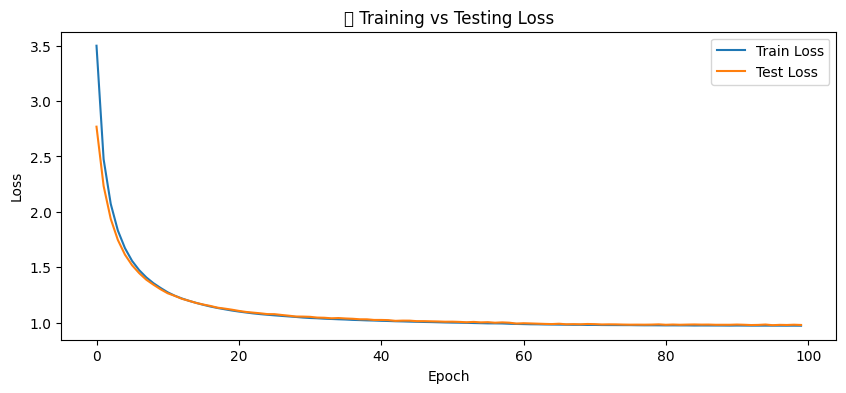

In [2]:
# ==============================================================
# 🎶 2 Hidden Layer ANN for Spotify Genre Classification
# ==============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ---------------------------------------------------------------
# 1️⃣ Load and preprocess dataset
# ---------------------------------------------------------------
data_path = "/kaggle/input/-spotify-tracks-dataset/dataset.csv"
df = pd.read_csv(data_path)
print("Original shape:", df.shape)

df.dropna(inplace=True)
print("After dropping nulls:", df.shape)

# Drop unnecessary text columns
drop_cols = ['track_id', 'artists', 'album_name', 'track_name']
df = df.drop(columns=drop_cols)

# Features and target
target_col = 'track_genre'
X = df.drop(columns=[target_col])
y = df[target_col]

# Convert 'explicit' (bool) to int if present
if 'explicit' in X.columns:
    X['explicit'] = X['explicit'].astype(int)

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
print("🎵 Number of classes:", num_classes)

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for mini-batch training
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=128)

print(f"🧩 Input features: {X_train_tensor.shape[1]}, Classes: {num_classes}")

# ---------------------------------------------------------------
# 2️⃣ Define 2-hidden-layer ANN (Identity + Sigmoid)
# ---------------------------------------------------------------
class TwoHiddenANN(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, output_dim):
        super(TwoHiddenANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.identity = nn.Identity()         # 1st hidden layer (Identity)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.sigmoid = nn.Sigmoid()           # 2nd hidden layer (Sigmoid)
        self.fc3 = nn.Linear(hidden2, output_dim)
        self.logsoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.identity(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.logsoftmax(self.fc3(x))
        return x

# Initialize model
input_dim = X_train_tensor.shape[1]
model = TwoHiddenANN(input_dim=input_dim, hidden1=128, hidden2=64, output_dim=num_classes)
print(model)

# ---------------------------------------------------------------
# 3️⃣ Loss function & Optimizer (Mini-batch Gradient Descent)
# ---------------------------------------------------------------
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

# ---------------------------------------------------------------
# 4️⃣ Training loop (Mini-batch Gradient Descent)
# ---------------------------------------------------------------
epochs = 100
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss, correct_train, total_train = 0, 0, 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_train += (preds == y_batch).sum().item()
        total_train += y_batch.size(0)
    
    train_loss = total_train_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # Evaluate on test set
    model.eval()
    total_test_loss, correct_test, total_test = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_test_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_test += (preds == y_batch).sum().item()
            total_test += y_batch.size(0)

    test_loss = total_test_loss / len(test_loader)
    test_acc = 100 * correct_test / total_test

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:03d} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

# ---------------------------------------------------------------
# 5️⃣ Plot accuracy and loss
# ---------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("🎯 Training vs Testing Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Training vs Testing Loss")
plt.legend()
plt.show()
